# Writting the package documentation

We have made some good progress towards our first `v0.1.0` milestone. We have a fairly functional `Image` class in order to represent images loaded in memory. The next big step is to implement our addition function between two images.

## Experiment Test Driven Development

With this in mind, we are going to explore a new way of developing called TDD for Test Driven Development. The base idea of TDD is to start by implementing the unit tests before the functionality being tested. The rationale behind this approach is that, usually, the developer has a pretty good idea of the end result but a less clear idea of how this result will be achieved.

In our case, we know from our initial API reflexion that the expected result should be something like this:

```python
from calculator.image import Image
from calculator.add import add

img1 = Image.from_file("./image1.img")
img2 = Image.from_file("./image2.img")
img3 = add(img1, img2)
```

When you think about it, we almost have written our unit test already. Create a new file `tests/unittests/add_test.py` with the following content:

```python
import numpy as np
from numpy.testing import assert_array_equal

def test_image_addition(tmp_path):
    from calculator.add import add
    from calculator.image import Image
    
    (tmp_path / "image1.img").write_text("[[1, 2], [3, 4]]")
    (tmp_path / "image2.img").write_text("[[1, -1], [2, 0]]")

    img = add(
        Image.from_file(tmp_path / "image1.img"),
        Image.from_file(tmp_path / "image2.img"),
    )

    assert_array_equal(
        img._data,
        np.array([[2, 1], [5, 4]]),
    )
```

If you run the test suite, you'd get the following error:

```bash
$ pytest -vv tests
============================================== test session starts ==================================================
platform darwin -- Python 3.12.11, pytest-8.4.1, pluggy-1.6.0 -- /Users/nicolas.gensollen/miniforge3/envs/calculator/bin/python
cachedir: .pytest_cache
rootdir: /Users/nicolas.gensollen/GitRepos/calculator-lib
configfile: pyproject.toml
plugins: cov-6.2.1
collected 5 items

tests/unittests/add_test.py::test_image_addition FAILED                            [ 20%]
tests/unittests/image_test.py::test_image_instantiation PASSED                     [ 40%]
tests/unittests/image_test.py::test_image_data_set_correctly PASSED                [ 60%]
tests/unittests/image_test.py::test_bad_type_in_image_instantiation PASSED         [ 80%]
tests/unittests/image_test.py::test_image_from_file_constructor PASSED             [100%]

================================================ FAILURES =======================================================
___________________________________________ test_image_addition ________________________________________________

tmp_path = PosixPath('/private/var/folders/zk/9_vr9pfn69xcvgyvhkj59lpr000z9t/T/pytest-of-nicolas.gensollen/pytest-23/test_image_addition0')

    def test_image_addition(tmp_path):
>       from calculator.add import add
E       ImportError: cannot import name 'add' from 'calculator' (/Users/nicolas.gensollen/GitRepos/calculator-lib/src/calculator/__init__.py)

tests/unittests/add_test.py:2: ImportError
```

We get one failing test with an `ImportError`, which makes sense since we do not have an `add` module with an `add` function inside of it. Let's fix this error, and this error only: create a new file `src/calculator/add.py` with the following content:

```python
from .image import Image

def add(image1: Image, image2: Image) -> Image:
    pass
```

With this code, the test will be able to import an `add` function from the `add` module. Let's re-run our test suite. This time, we get a new error:

```python
tmp_path = PosixPath('/private/var/folders/zk/9_vr9pfn69xcvgyvhkj59lpr000z9t/T/pytest-of-nicolas.gensollen/pytest-28/test_image_addition0')

    def test_image_addition(tmp_path):
        from calculator._image import Image
        from calculator.add import add

        (tmp_path / "image1.img").write_text("[[1, 2], [3, 4]]")
        (tmp_path / "image2.img").write_text("[[1, -1], [2, 0]]")

        img = add(
            Image.from_file(tmp_path / "image1.img"),
            Image.from_file(tmp_path / "image2.img"),
        )

        assert_array_equal(
>           img._data,
            ^^^^^^^^^
            np.array([[2, 1], [5, 4]]),
        )
E       AttributeError: 'NoneType' object has no attribute '_data'

tests/unittests/add_test.py:16: AttributeError
```

This error is telling us that the result of the addition is None and that we cannot access the `_data` attribute of None since it doesn't exist. This, again, makes perfect sense that we have a None result since our add function doesn't return anything yet. Let's fix this issue:

```python
def add(image1: Image, image2: Image) -> Image:
    return Image.from_array([[1, 100], [-23, 0]])
```

If we re-run the test suite, we would get this new error:

```python
tmp_path = PosixPath('/private/var/folders/zk/9_vr9pfn69xcvgyvhkj59lpr000z9t/T/pytest-of-nicolas.gensollen/pytest-30/test_image_addition0')

    def test_image_addition(tmp_path):
        from calculator._image import Image
        from calculator.add import add

        (tmp_path / "image1.img").write_text("[[1, 2], [3, 4]]")
        (tmp_path / "image2.img").write_text("[[1, -1], [2, 0]]")

        img = add(
            Image.from_file(tmp_path / "image1.img"),
            Image.from_file(tmp_path / "image2.img"),
        )

>       assert_array_equal(
            img._data,
            np.array([[2, 1], [5, 4]]),
        )
E       AssertionError:
E       Arrays are not equal
E
E       Mismatched elements: 4 / 4 (100%)
E       Max absolute difference among violations: 99
E       Max relative difference among violations: 99.
E        ACTUAL: array([[  1, 100],
E              [-23,   0]])
E        DESIRED: array([[2, 1],
E              [5, 4]])

tests/unittests/add_test.py:16: AssertionError
```

Obviously, the test is failing because the returned image does not have the expected data. By now, you probably get the idea of TDD so let's finish our add function:

```pyhon
def add(image1: Image, image2: Image) -> Image:
    return Image.from_array(image1._data + image2._data)
```

If you re-run the tests, they should all pass now. First of all, remember this is a toy example and the package we are implementing doesn't really make sense (we are basically re-implementing the addition between 2D arrays...). It's the process that we follow which matters.

Second, you might think TDD in a waste of time since we could have immediately written this one line long function without going through all those steps. It's True for this simple example, but in more complex situations, TDD can be of great help and guide you, step by step, toward your objective. Moreover, it's also a way to guarantee that your code will be tested, which can be often overlooked once the implementation step is finished...

Third, you might have noticed that we doing something bad in our add function: we are accessing a private attribute of our Image class to perform the addition. It's easy to see because we applied the "_" rule. We need to fix this! One way would be to turn the attribute public, but that's not what we want. We initialy turned this attribute private because we don't want users to alter the image data. One possible solution is to make this attribute read-only but not mutable. In Python you can do this with the `@property` decorator. Let's modify our `Image` class like this:

```python
    (...)
    
    @property
    def data(self) -> np.ndarray:
        return self._data

    @classmethod
    def from_array(cls, data: list):
        (...)
```

We can then modify the code of the add function:

```python
def add(image1: Image, image2: Image) -> Image:
    return Image.from_array(image1.data + image2.data)
```

And verify that we didn't break anything by running the tests.

## Configure and build our documentation

We are about to commit our code but suddenly it strikes us! We forgot what developers forget even more than unit tests... documentation.

Now that this poped in our mind, it's actually true that our prefered tools usually have this spot in our hearts because of their well thought, nice looking and welcoming documentation. We got to use these successful tools because it was easy and quick to find installation instructions, there was a super fast quick start tutorial to make the "Hello World" of the package run, a detailed user guide with plenty of examples, and a well crafted API documentation to be sure to know how to interact with the API.

If we want our package to be successful, actually even usable by other people, we need to write documentation. There's no way around it.

OK, so let's go for it !

### Generating a basic welcome page with Sphinx

As always in the Python world, there are several tools to do the job. The most famous tool for managing the documentation of a Python package is Sphinx, but there are pretty cool alternatives like mkdocs for example. Actually, in the Aramis team both Sphinx and mkdocs are used.

In this tutorial, we need to make a choice, so we'll go with Sphinx. We can install Sphinx using Poetry, but we'll create another group of dependencies nammed "docs" which will contain the documentation specific dependencies:

```bash
$ poetry add sphinx --group docs
Using version ^8.2.3 for sphinx

Updating dependencies
Resolving dependencies... (3.0s)

Package operations: 20 installs, 0 updates, 0 removals

  - Installing certifi (2025.6.15)
  - Installing charset-normalizer (3.4.2)
  - Installing idna (3.10)
  - Installing markupsafe (3.0.2)
  - Installing urllib3 (2.5.0)
  - Installing alabaster (1.0.0)
  - Installing babel (2.17.0)
  - Installing docutils (0.21.2)
  - Installing imagesize (1.4.1)
  - Installing jinja2 (3.1.6)
  - Installing requests (2.32.4)
  - Installing roman-numerals-py (3.1.0)
  - Installing snowballstemmer (3.0.1)
  - Installing sphinxcontrib-applehelp (2.0.0)
  - Installing sphinxcontrib-devhelp (2.0.0)
  - Installing sphinxcontrib-htmlhelp (2.1.0)
  - Installing sphinxcontrib-jsmath (1.0.1)
  - Installing sphinxcontrib-qthelp (2.0.0)
  - Installing sphinxcontrib-serializinghtml (2.0.0)
  - Installing sphinx (8.2.3)

Writing lock file
```

Poetry updated our package specifications in `pyproject.toml`:

```toml
(...)
[tool.poetry.group.docs.dependencies]
sphinx = "^8.2.3"
(...)
```

In the same way as we created a "tests" folder to contain our tests, we will create a "docs" folder to contain all documentation specific files:

```bash
$ mkdir docs
$ cd docs
```

When installing Sphinx, we installed a small helper tool called `sphinx-quickstart` that you can use to start configuring your documentation. Similarly to what we did with `poetry init`, this tool will ask a few questions on your package and automatically generate boilerplate code to get started writing the documentation:

```bash
$ sphinx-quickstart
$ tree
.
├── Makefile
├── _build
├── _static
├── _templates
├── conf.py
├── index.rst
└── make.bat

4 directories, 4 files
```

We can see that Sphinx created a `Makefile` for us. You can type `make` to get the list of available commands. To build the documentation, just run:

```bash
$ make html
```

If successful, this command should have generated a folder called `_build` with a subfolder called `html` which contains the html files of our documentation:

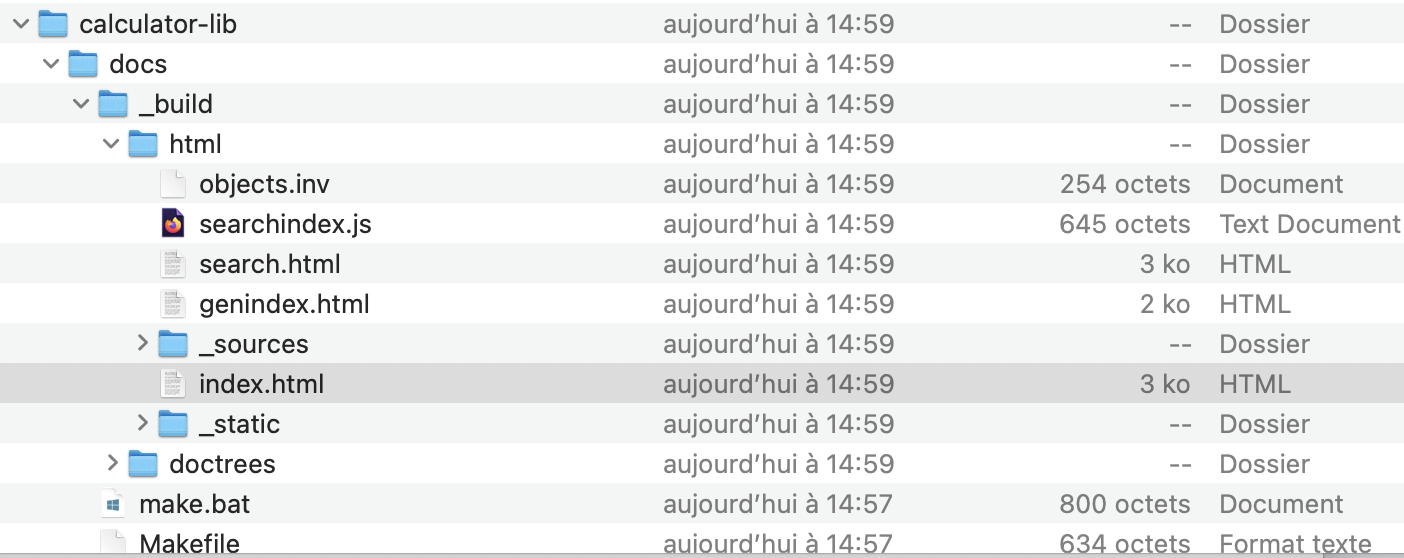

In [1]:
from IPython.display import Image

Image(filename="../images/index_doc.png")

If you open `index.html` with a web browser, you should see a page looking like this one:

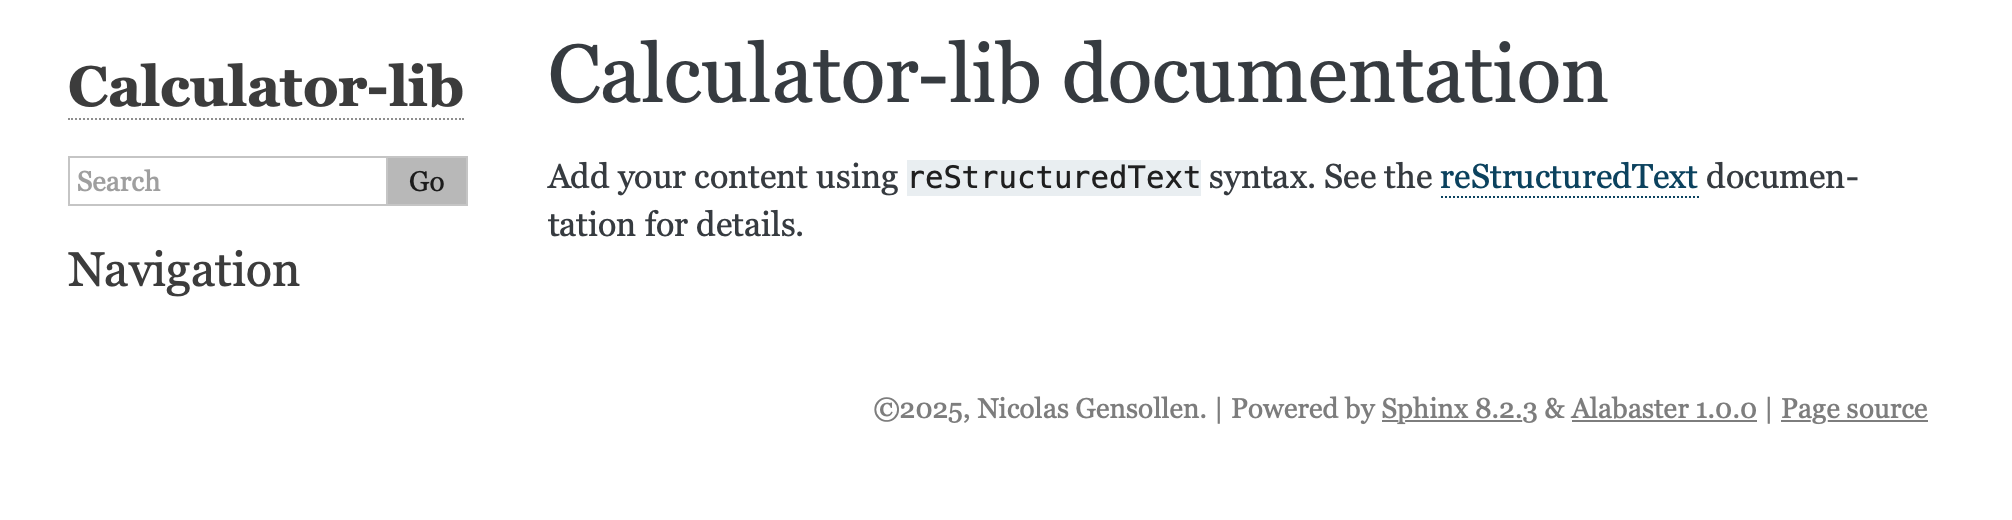

In [2]:
Image(filename="../images/documentation_1.png")

### Make changes to the documentation

This is the most basic welcome page possible filled with the information that you provided to Sphinx.

The important thing to understand is that you don't write these html pages directly, they are the result of the Sphinx build process which takes files in `rst` format. For example, the welcome page that we just opened corresponds to the `index.rst` file that you have at the root of the `docs` folder. You can open this file in your editor and modify the text for example:

```rst
.. Calculator-lib documentation master file, created by
   sphinx-quickstart on Fri Jun 20 14:57:31 2025.
   You can adapt this file completely to your liking, but it should at least
   contain the root `toctree` directive.

Calculator-lib documentation
============================

This is the documentation of the image calculator library. It's gonna be great!


.. toctree::
   :maxdepth: 2
   :caption: Contents:
```

If you re-build the documentation and refresh the page, you should see the modifications:

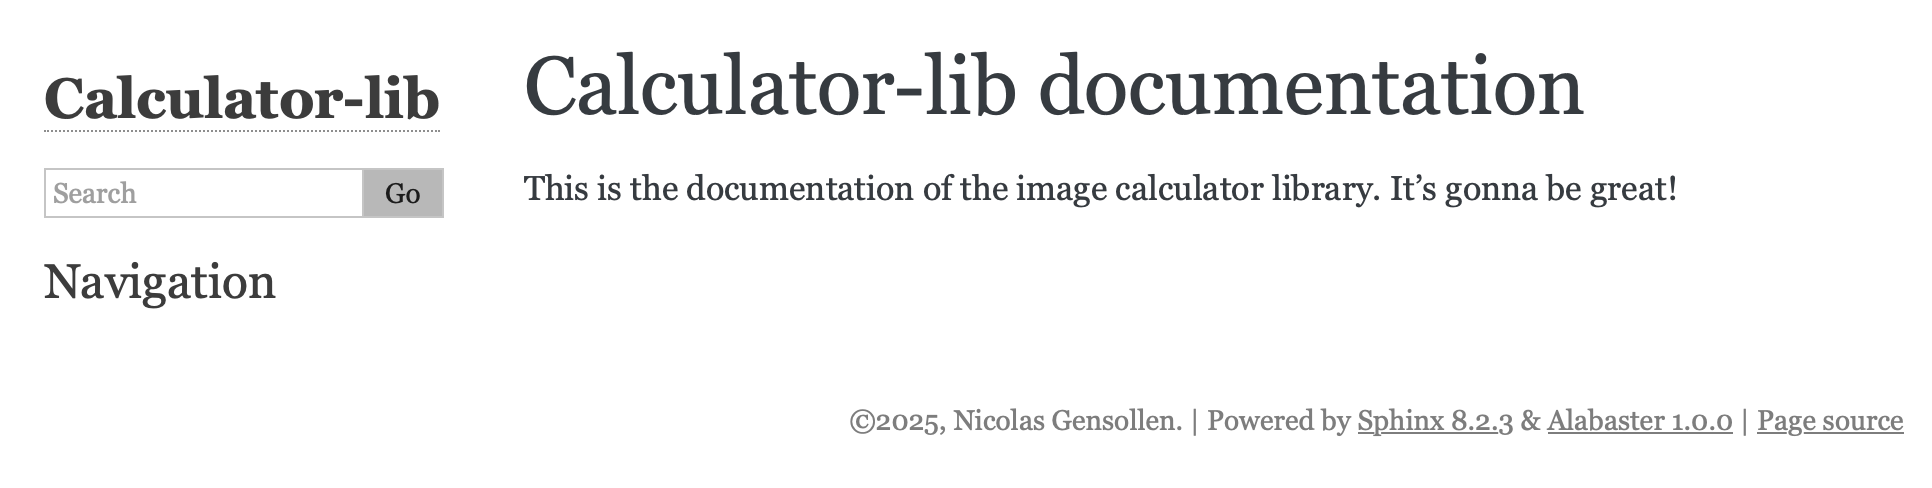

In [3]:
Image(filename="../images/documentation_2.png")

### Use markdown to write our documentation

`rst` stands for *restrucutred text format* and is a convenient way to quickly and easily write documentation. It is similar to the simpler and well-known `markdown` language although it is a bit more powerful. Still, there can be some projects in which contributors do not feel comfortable writing `rst` code and you'd want to configure things to be written in `markdown`.

There is a tool called `myst-nb` which can allow us to do so. Let's install it with Poetry:

```bash
$ poetry add myst-nb --group docs
```

Once installed, we need to tell Sphinx that it should use this extension. When it comes to configuring Sphinx, everything goes through the `conf.py` file located at the root of the docs folder. Open it and locate a variable named `extensions` which should be an empty list at this point. Add `myst_nb` to it:

```python
(...)
extensions = [
    "myst_nb",
]
(...)
```

Let's verify that we can write things in markdown now. Create a file named `quick_start.md` at the same level as `index.rst` and write the following content (note that this is pure `markdown` code):

```markdown
# Quick start with Calculator-lib

This page describes how to quickly get started with the package.

## Install the package

TODO.
```

We also need to link this new page to the index of our documentation, such that we can navigate to it. Open the `index.rst` file and modify the toctree by adding a new page named "quick_start":

```rst
.. toctree::
   :maxdepth: 2
   :caption: Contents:

   quick_start
```

Re-build the documentation and refresh your browser, you should now see the new page in the left navigation menu. The markdwon code of the new page should have correctly been converted to html:

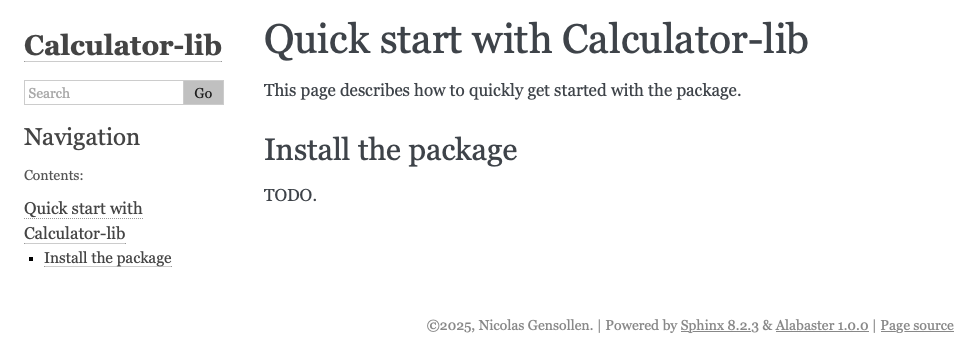

In [4]:
Image(filename="../images/quick-start.png")

Now that we have this in place, we "only" have to write our documentation pages using `rst` or `markdown`. Before we move on, there is one more important concept to talk about: the API reference.

### The API reference

The API reference is a key part of a package's documentation. It can be seen as an organized list of public objects (functions, classes...) that the users can interact with. Each object must have a detailed description of what it does as well as a list of parameters with data types and descriptions as well.

Now, we *could* do that with what we just learned, we would create a mardown file per module and detail what's inside. For instance, for our `add` function we could come up with something like that:

```markdown
## function add(image1: Image, image2: Image) -> Image

Adds two images element-wise and returns a new image object.

### Inputs

image1: Image, the first image to be added.
image2: Image, the second image to be added.

### Outputs

Image : A new Image object holding the sum of the provided images.
```

This would work but that would be a terrible way to handle the documentation of our API and for multiple reasons:

- First, the documentation of an object is **totally decoupled from the code**. No need to say that developpers in the rush will soon forget to update the documentation to reflect the modifications that they just made. Soon enough, the code and its documentation will be completely out-of-sync.
- Second, when reading the code, a developper has no way to get the documentation other than going to the docs and finding the corresponding page. When navigating a complex code base, this can quickly become very annoying. Ideally, we'd like to have the same information in the code files.
- Third, it's a lot of extra work to manage all these markdown files as well as the formatting of everything. In addition, what if we want to change the look of our API doc, we would have to update all those small files one by one...

#### Using sphinx-autoapi to generate documentation from docstrings

Luckily there are solutions to these problems. The base idea is to document each object only once: in the code where the object is defined. For that purpose we use Python docstrings but we enforce some rules on how to organize and format the information. There exists various coventions to do that, but one of the most popular is [numpydoc](https://numpydoc.readthedocs.io/en/latest/format.html) which comes from the rules that the famous Numpy package used.

Numpydoc gives us only formatting rules of our docstrings. In order to render these docstrings automatically in our documentation pages we need another tool called `sphinx-autoapi`. Let's, once again, install it with Poetry:

```bash
$ poetry add sphinx-autoapi --group docs
```

Once installed, as for `myst_nb`, you need to add the extension to the configuration file `conf.py`:

```python
(...)
extensions = [
    "myst_nb",
    "autoapi.extension",
]

templates_path = ['_templates']
exclude_patterns = ['_build', 'Thumbs.db', '.DS_Store']

autoapi_dirs = ['../src']
```

Make sure to set the `autoapi_dirs` variable in oder for auto-api to be able to find your code files.

We are going to use the type hints of our Python code to automatically fill in the argument types in the description with links to the objects. To do that, add the following lines in `conf.py`:

```python
autodoc_typehints = "description"
python_use_unqualified_type_names = True
autodoc_type_aliases = {
    "Image": "calculator._image.Image",
}
```

Alright! That's enough configuration. Let's come back to our `add` function and write the following docstring:

```python
def add(image1: Image, image2: Image) -> Image:
    """Add the two provided images element-wise.

    :param image1: The first image to be added.

    :param image2: The second image to be aded.

    :returns: A new Image object holding the sum of the provided images.

    Examples
    --------
    >>> from calculator import add, Image
    >>> image1 = Image.from_array([[1, 2], [3, 4]])
    >>> image2 = Image.from_array([[1, 1], [1, 1]])
    >>> image3 = add(image1, image2)
    >>> image3.data
    array([[2, 3],
           [4, 5]])
    """
    return Image.from_array(image1.data + image2.data)
```

Finally, let's update the file `src/calculator/__init__.py` that we haven't touched since the begining of this tutorial. Remember that our API objective was:

```python
from calculator import add, Image
```

not

```python
from calculator.add import add
from calculator.image import Image
```

One way to do that is to put the following content in `src/calculator/__init__.py`:

```python
from .image import Image
from .add import add

PI = 3.1415

__all__ = [
    "add",
    "Image",
    "PI",
]
```

Re-build the doc and refresh the page. In the left menu, you should see a new "API Reference" link. Clicking on it, you should be able to navigate to the documentation page for the `add` function:

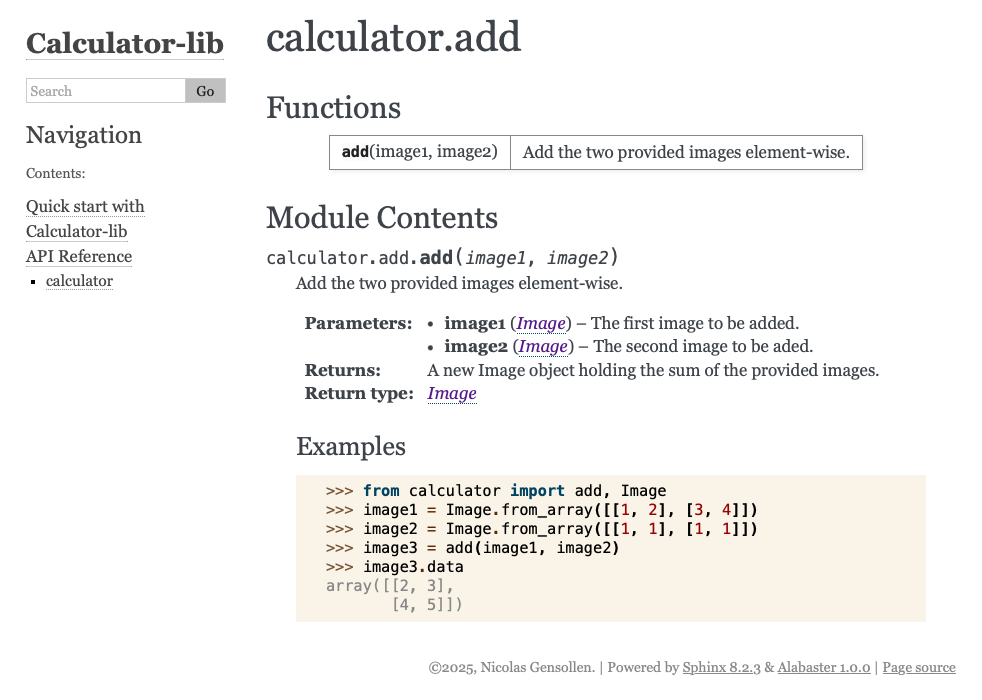

In [5]:
Image(filename="../images/doc_add.png")

As you can see, Sphinx was able to parse our docstring and generate a pretty rich and good-looking documentation page. This is the page that users will take a look at when trying to remember how to use our `add` function.

#### Configuring what to document and what not

Imagine now that we want to improve the robustness of our addition code a bit. For example, at the moment, there is nothing stopping users to do something like that:

```python
>>> from calculator import Image, add
>>> img1 = Image.from_array([[1, 2],[3, 4]])
>>> img2 = Image.from_array([[1, 2, 3], [4, 5, 6]])
>>> add(img1, img2)
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
  File "/Users/nicolas.gensollen/GitRepos/calculator-lib/src/calculator/add.py", line 28, in add
    return Image.from_array(image1.data + image2.data)
                            ~~~~~~~~~~~~^~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (2,2) (2,3)
```

These images cannot be added element-wise because their shapes differ and there is no way to use broadcasting rules to make the shapes correspond. The error is already pretty clear (thanks Python 3.12!!), but let's say we want to improve it to provide a better user experience.

We are going to add a small check before performing the array addition, we already feel that this check is going to be useful later for other operations so we put it in a small private functions:

```python
def add(image1: Image, image2: Image) -> Image:
    """Add the two provided images element-wise.
    ...
    """
    _check_images_compatibility(image1, image2)
    return Image.from_array(image1.data + image2.data)


def _check_images_compatibility(image1: Image, image2: Image):
    try:
        np.broadcast_shapes(image1.data.shape, image2.data.shape)
    except ValueError:
        raise ValueError(
            "Provided images have incompatile shapes.\n"
            f"Image 1 is {image1.data.shape}.\n"
            f"Image 2 is {image2.data.shape}."
        )
```

Such that we now get this error instead:

```python
>>> add(img1, img2)
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
  File "/Users/nicolas.gensollen/GitRepos/calculator-lib/src/calculator/add.py", line 27, in add
    _check_images_compatibility(image1, image2)
  File "/Users/nicolas.gensollen/GitRepos/calculator-lib/src/calculator/add.py", line 35, in _check_images_compatibility
    raise ValueError(
ValueError: Provided images have incompatile shapes.
Image 1 is (2, 2).
Image 2 is (2, 3).
```

Let's rebuild our doc and refresh the API documentation. We should have something like this where both functions are documented:

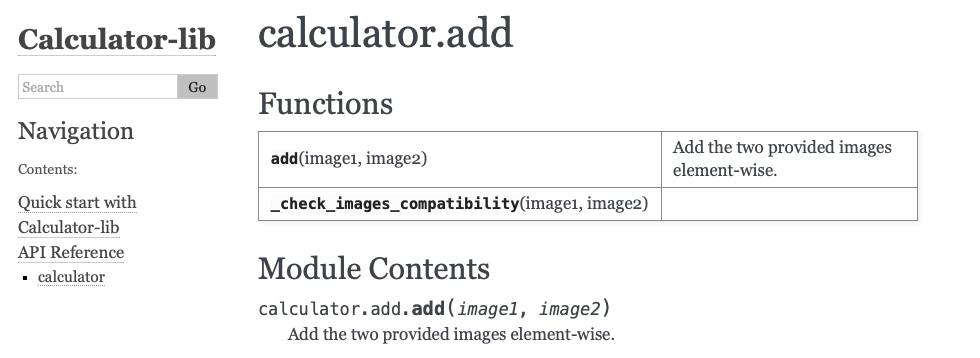

In [6]:
Image(filename="../images/api_with_private.png")

This is annoying because we don't want our users to know about this function. We don't want to write a docstring for it, or at least not as well written as the one we have for `add`. Moreover, we haven't thought deeply about this function and we'd like to have the possibility to completely modify it later, or even remove it without having angry users knocking at our door...

We can help Sphinx to know which objects to document and which objects to ignore through the `__all__` list that we put at the begining of `src/calculator/add.py`, just after the imports:

```python
import ...

__all__ = ["add"]

def add(...):
    ...

def _check_images_compatibility(...):
    ...
```

If you rebuild the documentation, you should now only see the `add` function.

In the Aramis team we have the convention of using `__all__` consistently as it is a very convenient way to know what objects a module is exporting.

Take the time to commit and push what we've done so far. Open a Pull Request and merge:

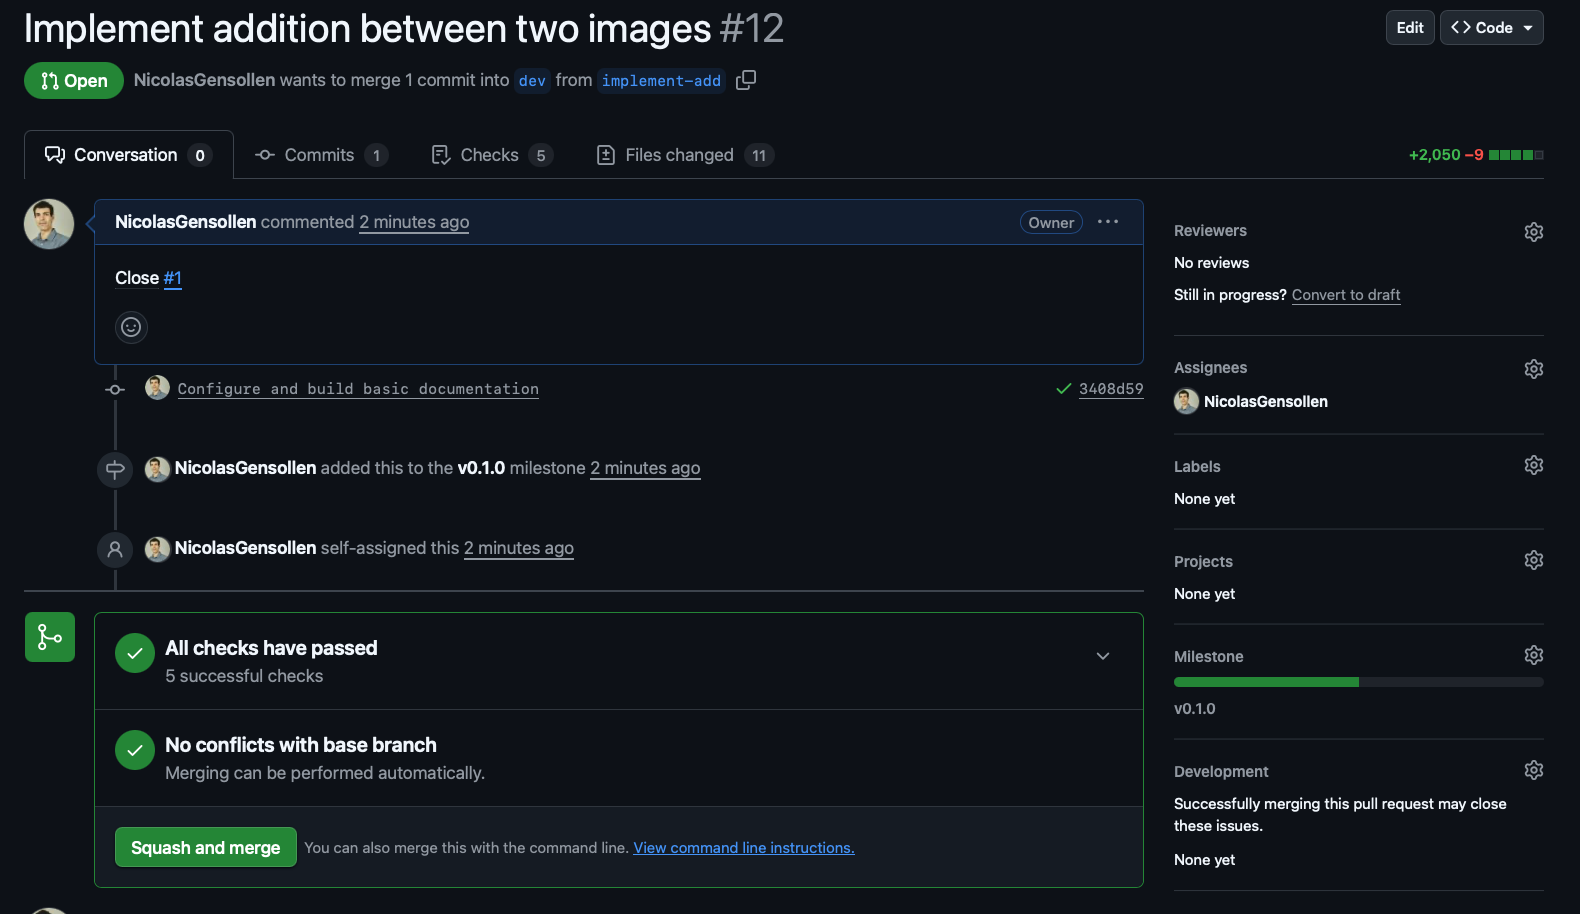

In [7]:
Image(filename="../images/pr_addition.png")

## Deploy the documentation 

At this point, we have everything we need to write and build a good documentation locally on our computers. However, most users aren't going to build the doc themselves to understand how our package works. They expect to have an online version easily accessible that they can browse. When building a package it is very important to make our documentation available to users in such a way.

Sphinx and related tools are doing the work of generating html pages from our source files such that we only need a way to *host* these html pages on a webserver to make them available. There are, of course, a lot of ways to achieve that. From serving them from your personal webserver to using a hosting service. 

There is one very handy tool that does everything from building to deploying and hosting multiple versions of a package's documentation: [read the docs](https://docs.readthedocs.com/platform/stable/).

To benefit from readthedocs you need to register on their platform, but since you can use GitHub to sign-in there is basically nothing to do. Your project also needs to be public (which should be the case here if you followed along). For private projects, other solutions should be used such as self-hosting the documentations.

There are two things to do to start a new project:

- Add a configuration file to the repository (it will tell read the docs how to build your project)
- Add the project on the ReadtheDocs platform to start triggering builds

Let's work on step 1 first. The configuration file for readthedocs is named `.readthedocs.yaml` and is located at the root of the project. You can use the following configuration:

```yaml
version: 2

build:
  os: ubuntu-22.04
  tools:
    python: "3.12"
  jobs:
    post_create_environment:
      - pip install poetry
      - poetry config virtualenvs.create false
      - . "$READTHEDOCS_VIRTUALENV_PATH/bin/activate" && poetry install --with docs
      - pip freeze

sphinx:
  configuration: docs/conf.py
```

That's all you need and you're not going to modify this file much in the future, but it's good to remember it's existence when things go wrong on the documentation front.

For step 2, let's open a web browser and go to your readthedocs profile. Click on "Add a project" and select the repository you've been using for the calculator package:

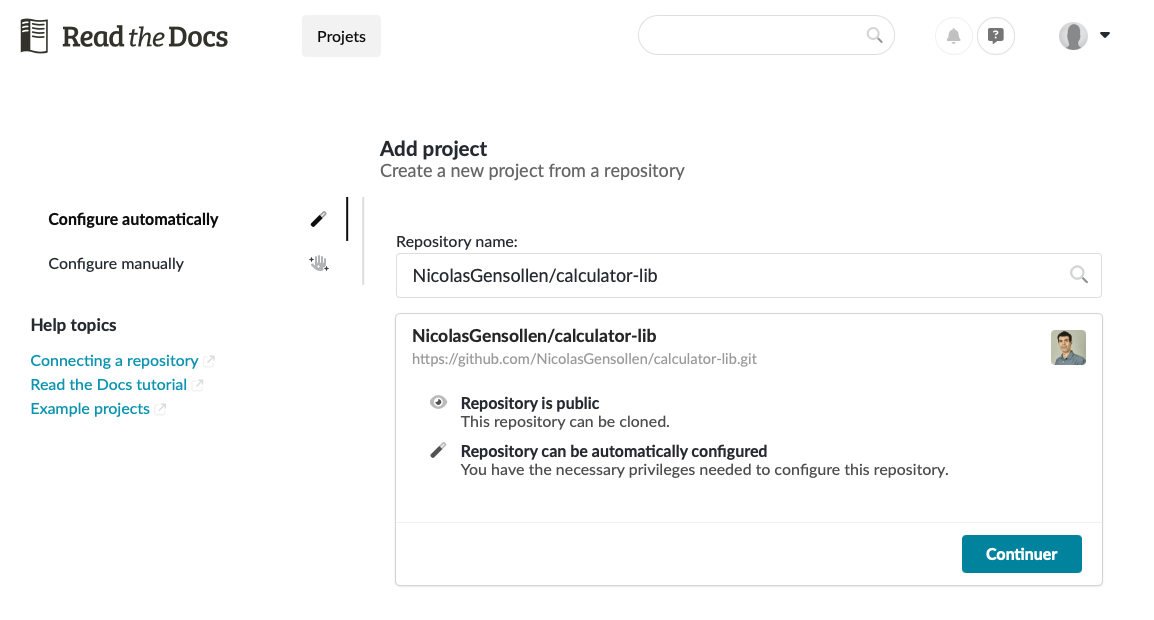

In [8]:
Image(filename="../images/rtd_add_project.png")

Click on "Continuer" and make sure to change the default branch to be `dev` since this is the branch on which we are working at the moment:

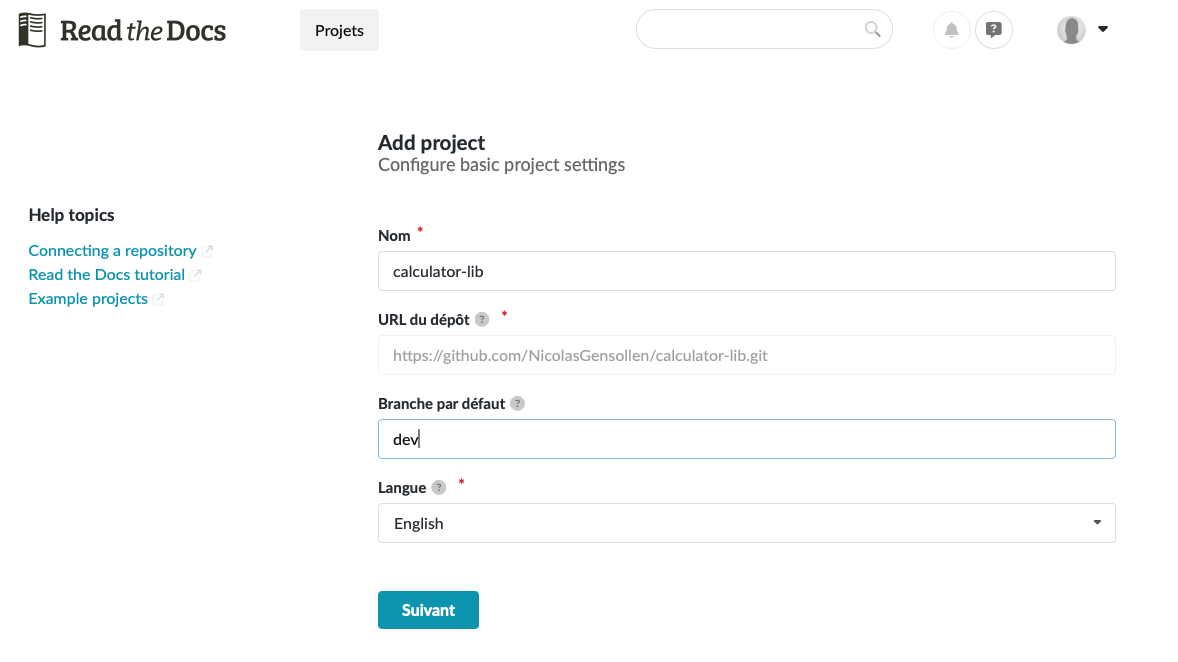

In [9]:
Image(filename="../images/rtd_add_project_2.png")

If all went well, you should get to a page like this with a green tick mark meaning that Read the docs was able to build and deploy your documentation automatically:

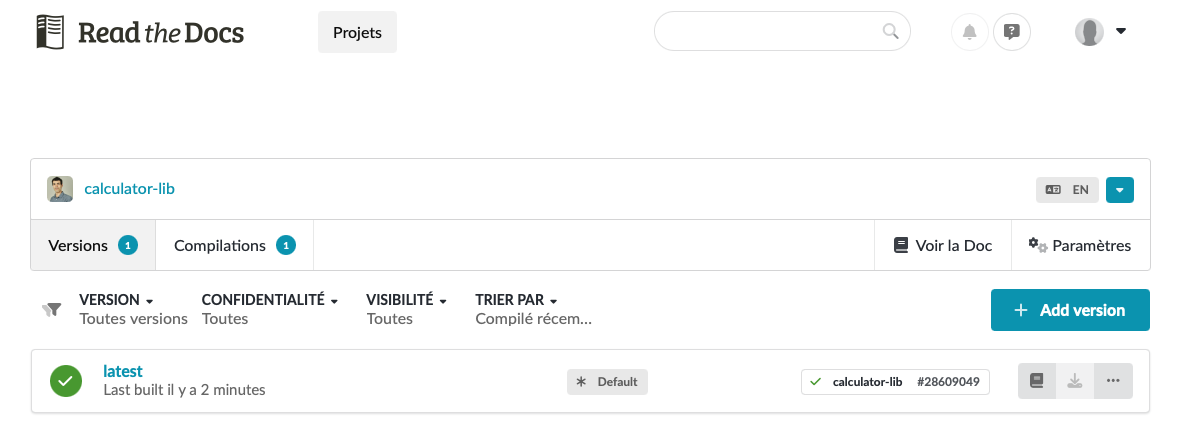

In [10]:
Image(filename="../images/rtd_add_project_3.png")

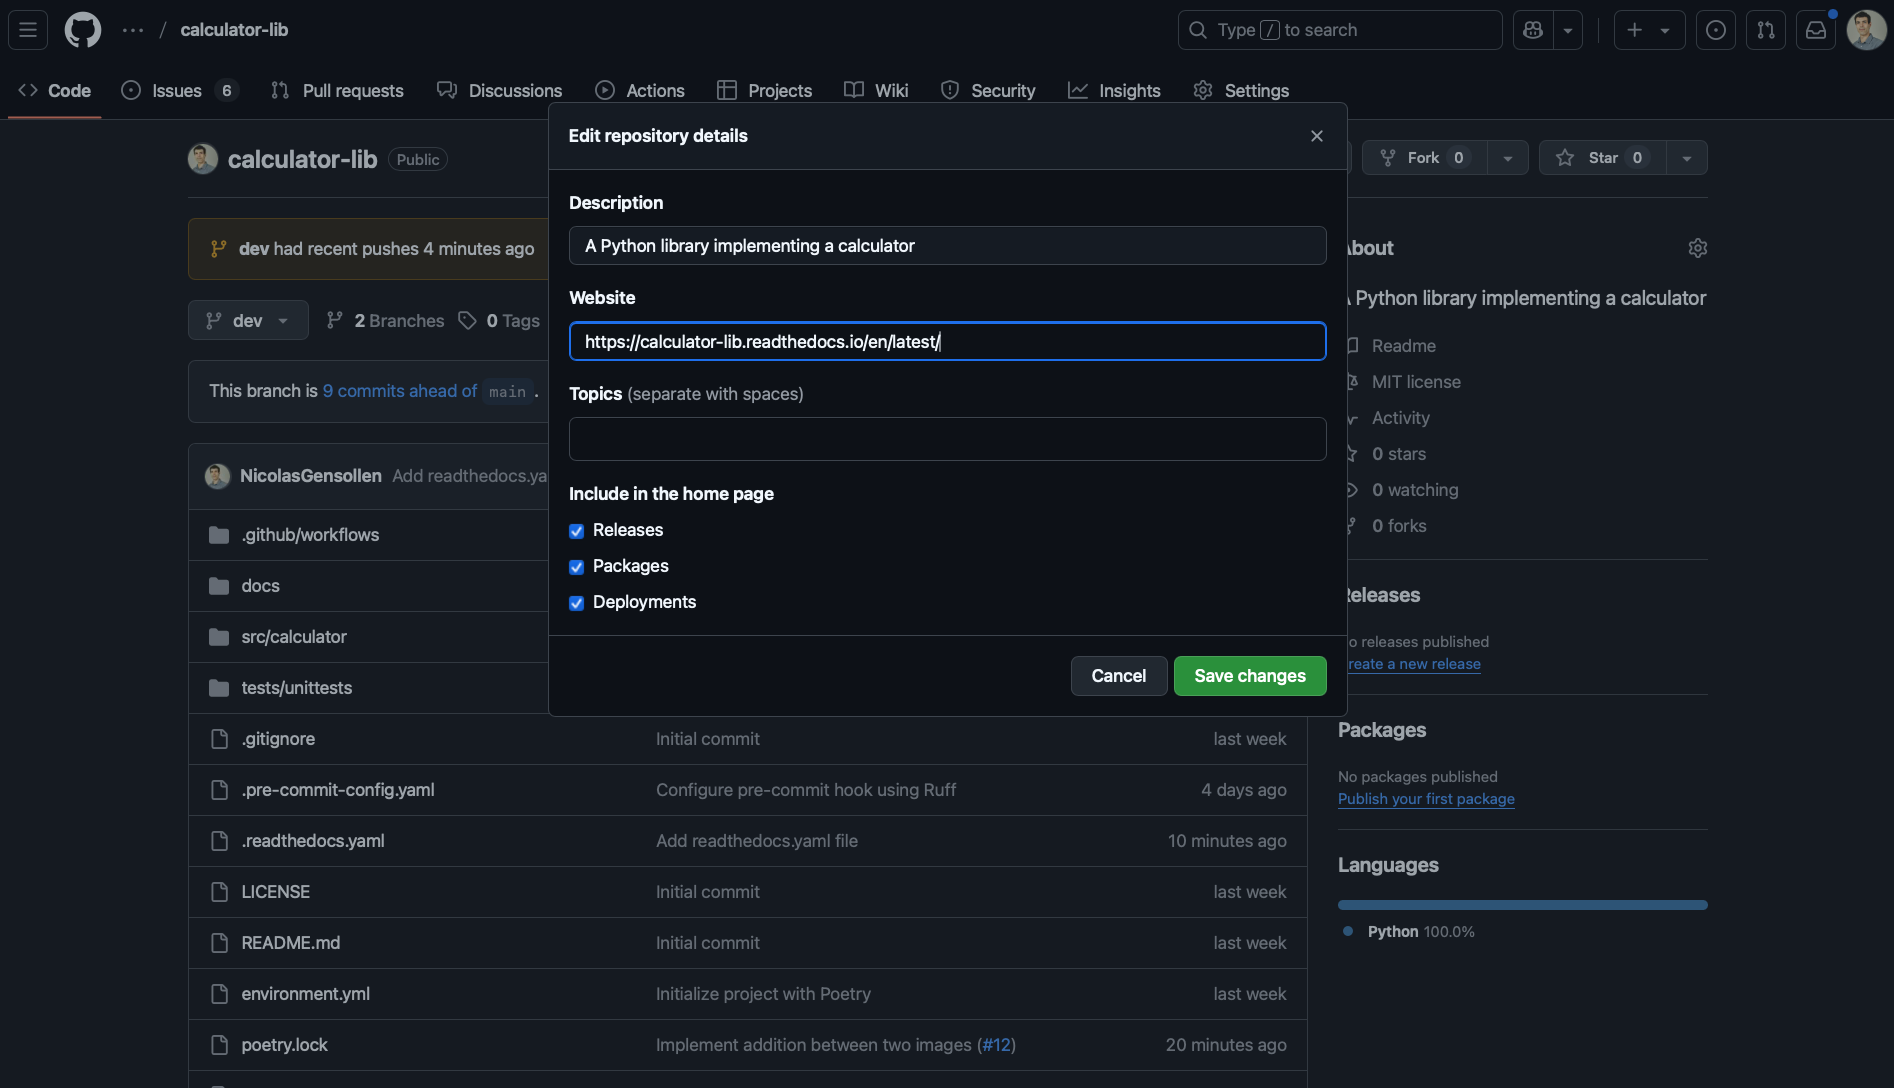

In [11]:
Image(filename="../images/add_doc_link.png")

That's it for this chapter on documentation! You are now able to configure, write, build, and deploy your documentation. Moreover you had a taste of very useful tools in the area of documentation such as `myst_nb` for writting pages in markdown, or sphinx-autoapi for generating API reference pages automatically from the code docstrings. You also gain some insights into how to write good and nice looking docstrings and how to differentiate public vs. private objects both in code and in documentation.

We've made some decent progree and the next chapter will lead us to our first milestone objective: publishing our package in a `v0.1.0` such that other users can download and use it accross the world.